# Лабораторная работа 3: Генерация текста

## Import libs

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
import torch.nn.init as init
import torch.autograd as autograd
import sys
import warnings
from torch.utils.data import DataLoader
from tqdm import tqdm
warnings.filterwarnings('ignore')


## Get data

In [2]:
with open('data/shakespeare.txt', 'r') as input_file:
    lines = input_file.readlines()

processed_lines = [line.strip() for line in lines if line.strip() and '     ' not in line]

with open('data/shakespeare_processed.txt', 'w') as output_file:
    output_file.write('\n'.join(processed_lines))
    

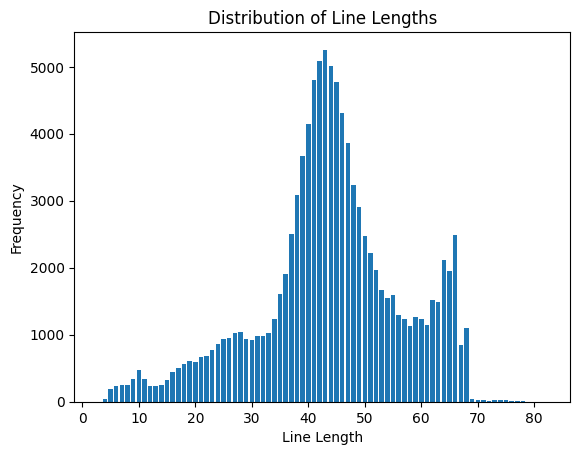

In [3]:
import matplotlib.pyplot as plt

with open('data/shakespeare_processed.txt', 'r') as file:
    lines = file.readlines()

line_lengths = [len(line) for line in lines]

length_counts = {}
for length in line_lengths:
    length_counts[length] = length_counts.get(length, 0) + 1

plt.bar(length_counts.keys(), length_counts.values())
plt.xlabel('Line Length')
plt.ylabel('Frequency')
plt.title('Distribution of Line Lengths')
plt.show()


In [4]:
with open('data/shakespeare_processed.txt', 'r') as file:
    lines = file.readlines()

filtered_lines = [line for line in lines if len(line) >= 42]
truncated_lines = [line[:42] + '\n' for line in filtered_lines]
cleaned_lines = [line.strip('\n') + '\n' for line in truncated_lines]

with open('data/shakespeare_filtered.txt', 'w') as file:
    file.writelines(cleaned_lines)
    

In [5]:
def calculate_vocab_size(file_path):
    unique_chars = set()

    with open(file_path, 'r') as file:
        for line in file:
            unique_chars.update(line.strip())

    return len(unique_chars)

file_path = 'data/shakespeare_filtered.txt'
vocab_size = calculate_vocab_size(file_path)

print("Vocabulary Size:", vocab_size)


Vocabulary Size: 78


In [6]:
def create_vocab(file_path):
    with open(file_path, 'r') as file:
        text = file.read()

    unique_chars = list(set(text))
    vocab = {char: idx for idx, char in enumerate(unique_chars)}

    return vocab

def encode_text(text, encoding_dict):
    return [encoding_dict[char] for char in text]

def decode_indices(indices, decoding_dict):
    return ''.join(decoding_dict[idx] for idx in indices)

# encoding_dict = create_vocab('data/shakespeare_filtered.txt')
# decoding_dict = {idx: char for char, idx in encoding_dict.items()}


In [7]:
encoding_dict = {'2': 0,
                 'W': 1,
                 'E': 2,
                 's': 3,
                 '.': 4,
                 'O': 5,
                 'q': 6,
                 'z': 7,
                 't': 8,
                 '?': 9,
                 '8': 10,
                 '(': 11,
                 'V': 12,
                 'H': 13,
                 ')': 14,
                 ';': 15,
                 'w': 16,
                 '"': 17,
                 ':': 18,
                 ',': 19,
                 'c': 20,
                 'G': 21,
                 'd': 22,
                 'N': 23,
                 'i': 24,
                 'C': 25,
                 'L': 26,
                 '3': 27,
                 'x': 28,
                 'R': 29,
                 '!': 30,
                 '7': 31,
                 'B': 32,
                 'T': 33,
                 "'": 34,
                 '<': 35,
                 '-': 36,
                 'j': 37,
                 'h': 38,
                 '\n': 39,
                 'p': 40,
                 'n': 41,
                 '9': 42,
                 '&': 43,
                 'k': 44,
                 '6': 45,
                 'U': 46,
                 'Q': 47,
                 'y': 48,
                 'b': 49,
                 'P': 50,
                 'I': 51,
                 'a': 52,
                 '5': 53,
                 '0': 54,
                 'm': 55,
                 'K': 56,
                 'l': 57,
                 'S': 58,
                 'r': 59,
                 'X': 60,
                 'e': 61,
                 'M': 62,
                 '[': 63,
                 'f': 64,
                 'o': 65,
                 'g': 66,
                 '1': 67,
                 '`': 68,
                 'v': 69,
                 'J': 70,
                 'Z': 71,
                 'A': 72,
                 ']': 73,
                 'D': 74,
                 'F': 75,
                 'u': 76,
                 'Y': 77,
                 ' ': 78}


In [8]:
decoding_dict = {0: '2',
                 1: 'W',
                 2: 'E',
                 3: 's',
                 4: '.',
                 5: 'O',
                 6: 'q',
                 7: 'z',
                 8: 't',
                 9: '?',
                 10: '8',
                 11: '(',
                 12: 'V',
                 13: 'H',
                 14: ')',
                 15: ';',
                 16: 'w',
                 17: '"',
                 18: ':',
                 19: ',',
                 20: 'c',
                 21: 'G',
                 22: 'd',
                 23: 'N',
                 24: 'i',
                 25: 'C',
                 26: 'L',
                 27: '3',
                 28: 'x',
                 29: 'R',
                 30: '!',
                 31: '7',
                 32: 'B',
                 33: 'T',
                 34: "'",
                 35: '<',
                 36: '-',
                 37: 'j',
                 38: 'h',
                 39: '\n',
                 40: 'p',
                 41: 'n',
                 42: '9',
                 43: '&',
                 44: 'k',
                 45: '6',
                 46: 'U',
                 47: 'Q',
                 48: 'y',
                 49: 'b',
                 50: 'P',
                 51: 'I',
                 52: 'a',
                 53: '5',
                 54: '0',
                 55: 'm',
                 56: 'K',
                 57: 'l',
                 58: 'S',
                 59: 'r',
                 60: 'X',
                 61: 'e',
                 62: 'M',
                 63: '[',
                 64: 'f',
                 65: 'o',
                 66: 'g',
                 67: '1',
                 68: '`',
                 69: 'v',
                 70: 'J',
                 71: 'Z',
                 72: 'A',
                 73: ']',
                 74: 'D',
                 75: 'F',
                 76: 'u',
                 77: 'Y',
                 78: ' '}


## Prepare dataset

In [9]:
import torch
torch.manual_seed(42);


In [10]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, file_path, encoding_dict, num_lines=None):
        with open(file_path, 'r') as file:
            lines = file.readlines()[:num_lines]

        self.encoded_lines = [self.encode_line(line, encoding_dict) for line in lines]

    def __len__(self):
        return len(self.encoded_lines)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded_lines[idx])

    def encode_line(self, line, encoding_dict):
        return [encoding_dict[char] for char in line.strip()]

def decode_line(indices, decoding_dict):
    return ''.join(decoding_dict[idx] for idx in indices)

dataset = TextDataset('data/shakespeare_filtered.txt', encoding_dict, num_lines=1000)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for batch in dataloader:
    print(batch)
    encoded_line = batch.squeeze().tolist()
    decoded_line = decode_line(encoded_line, decoding_dict)

    print(f"Encoded Line: {encoded_line}")
    print(f"Decoded Line: {decoded_line}")
    break


tensor([[32, 76,  8, 78,  8, 38, 52,  8, 78,  8, 38, 65, 76, 78, 41, 65, 41, 61,
         78, 57, 65, 69, 34,  3,  8, 78, 24,  3, 78, 55, 65,  3,  8, 78, 61, 69,
         24, 22, 61, 41,  8, 18]])
Encoded Line: [32, 76, 8, 78, 8, 38, 52, 8, 78, 8, 38, 65, 76, 78, 41, 65, 41, 61, 78, 57, 65, 69, 34, 3, 8, 78, 24, 3, 78, 55, 65, 3, 8, 78, 61, 69, 24, 22, 61, 41, 8, 18]
Decoded Line: But that thou none lov'st is most evident:


In [11]:
len(dataloader)

1000

## SeqGAN

In [21]:
def prepare_generator_batch(samples, start_letter=0, gpu=False):
    batch_size, seq_len = samples.size()

    inp = torch.zeros(batch_size, seq_len)
    target = samples
    inp[:, 0] = start_letter
    inp[:, 1:] = target[:, :seq_len-1]

    inp = autograd.Variable(inp).type(torch.LongTensor)
    target = autograd.Variable(target).type(torch.LongTensor)

    if gpu:
        inp = inp.cuda()
        target = target.cuda()

    return inp, target


def prepare_discriminator_data(pos_samples_loader, neg_samples, gpu=False):
    if isinstance(pos_samples_loader, DataLoader):
        pos_samples = []
        for batch in pos_samples_loader:
            if batch.shape < torch.Size((1, 42)):
                batch = torch.cat((batch,torch.full((1, torch.prod(torch.tensor((1, 42))) - torch.prod(torch.tensor(batch.shape))), 78)), dim=1)
            pos_samples.append(batch)
        pos_samples = torch.cat(pos_samples, 0).type(torch.LongTensor).cuda()
    else:
        pos_samples = pos_samples_loader
    
    inp = torch.cat((pos_samples, neg_samples), 0).type(torch.LongTensor)
    target = torch.ones(pos_samples.size()[0] + neg_samples.size()[0])
    target[pos_samples.size()[0]:] = 0

    perm = torch.randperm(target.size()[0])
    target = target[perm]
    inp = inp[perm]

    inp = autograd.Variable(inp)
    target = autograd.Variable(target)

    if gpu:
        inp = inp.cuda()
        target = target.cuda()

    return inp, target


def batchwise_sample(gen, num_samples, batch_size):
    samples = []
    for i in range(int(math.ceil(num_samples/float(batch_size)))):
        samples.append(gen.sample(batch_size))

    return torch.cat(samples, 0)[:num_samples]

def batchwise_oracle_nll(gen, oracle, num_samples, batch_size, max_seq_len, start_letter=0, gpu=False):
    s = batchwise_sample(gen, num_samples, batch_size)
    oracle_nll = 0
    for i in range(0, num_samples, batch_size):
        inp, target = prepare_generator_batch(s[i:i+batch_size], start_letter, gpu)
        oracle_loss = oracle.batchNLLLoss(inp, target) / max_seq_len
        oracle_nll += oracle_loss.data.item()

    return oracle_nll/(num_samples/batch_size)
    

## Generator

In [13]:
class Generator(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, max_seq_len, gpu=False, oracle_init=False):
        super(Generator, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.max_seq_len = max_seq_len
        self.vocab_size = vocab_size
        self.gpu = gpu

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim)
        self.gru2out = nn.Linear(hidden_dim, vocab_size)

        if oracle_init:
            for p in self.parameters():
                init.normal(p, 0, 1)
                
    def init_hidden(self, batch_size = 1):
        h = autograd.Variable(torch.zeros(1, batch_size, self.hidden_dim))
        
        if self.gpu:
            return h.cuda()
        else:
            return h
        
    def forward(self, inp, hidden):
        emb = self.embeddings(inp)
        emb = emb.view(1, -1, self.embedding_dim)
        out, hidden = self.gru(emb, hidden)
        out = self.gru2out(out.view(-1, self.hidden_dim))
        out = F.log_softmax(out)
        return out, hidden
    
    def sample(self, num_samples, start_letter=0):
        samples = torch.zeros(num_samples, self.max_seq_len).type(torch.LongTensor)

        h = self.init_hidden(num_samples)
        inp = autograd.Variable(torch.LongTensor([start_letter]*num_samples))

        if self.gpu:
            samples = samples.cuda()
            inp = inp.cuda()

        for i in range(self.max_seq_len):
            out, h = self.forward(inp, h)
            out = torch.multinomial(torch.exp(out), 1)
            samples[:, i] = out.view(-1)
            inp = out.view(-1)
        return samples

        
    def batchNLLLoss(self, inp, target):
        loss_fn = nn.NLLLoss()
        batch_size, seq_len = inp.size()
        inp = inp.permute(1, 0)
        target = target.permute(1, 0)
        h = self.init_hidden(batch_size)
        
        loss = 0
        for i in range(seq_len):
            out, h = self.forward(inp[i], h) # loss
            loss += loss_fn(out, target[i])
            
        return loss
    
    def batchPGLoss(self, inp, target, reward):
        batch_size, seq_len = inp.size()
        inp = inp.permute(1, 0)
        target = target.permute(1, 0)
        h = self.init_hidden(batch_size)
        
        loss = 0
        for i in range(seq_len):
            out, h = self.forward(inp[i], h)
            for j in range(batch_size):
                loss += -out[j][target.data[i][j]]* reward[j]
                
        return loss / batch_size

## Discriminator

In [14]:
class Discriminator(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, max_seq_len, gpu=False, dropout=0.2):
        super(Discriminator, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.max_seq_len = max_seq_len
        self.gpu = gpu
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, bidirectional=True, dropout=dropout)
        self.gru2hidden = nn.Linear(2*2*hidden_dim, hidden_dim) # (bidirectional * num_layers * hidden_dim, hidden_dim)
        self.dropout_linear = nn.Dropout(p=dropout)
        self.hidden2out = nn.Linear(hidden_dim, 1)
        
    def init__hidden(self, batch_size):
        h = autograd.Variable(torch.zeros(2*2*1, batch_size, self.hidden_dim))
        
        if self.gpu:
            return h.cuda()
        else:
            return h
    
    def forward(self, input, hidden):
        emb = self.embeddings(input)
        emb = emb.permute(1, 0, 2)
        _, hidden = self.gru(emb, hidden)
        hidden = hidden.permute(1, 0, 2).contiguous()
        out = self.gru2hidden(hidden.view(-1, 4*self.hidden_dim))
        out = F.tanh(out)
        out = self.dropout_linear(out)
        out = self.hidden2out(out)
        out = F.sigmoid(out)
        return out
    
    def batchClassify(self, inp):
        h = self.init__hidden(inp.size()[0])
        out = self.forward(inp, h)
        return out.view(-1)
    
    def batchBCELoss(self, inp, target):
        loss_fn = nn.BCELoss()
        h = self.init__hidden(inp.size()[0])
        out = self.forward(inp, h)
        return loss_fn(out, target)
        

In [15]:
CUDA = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
VOCAB_SIZE = 5000
MAX_SEQ_LEN = 42
START_LETTER = 0
BATCH_SIZE = 32
MLE_TRAIN_EPOCHS = 100
ADV_TRAIN_EPOCHS = 50
POS_NEG_SAMPLES = 1000

GEN_EMBEDDING_DIM = 32
GEN_HIDDEN_DIM = 32
DIS_EMBEDDING_DIM = 64
DIS_HIDDEN_DIM = 64


## Training

In [18]:
def train_generator_MLE(gen, gen_opt, oracle, real_data_samples, epochs, batch_size):
    for epoch in range(epochs):
        print('epoch %d : ' % (epoch + 1), end='')
        total_loss = 0

        for batch_data in tqdm(real_data_samples):
            inp, target = prepare_generator_batch(batch_data, start_letter=START_LETTER, gpu=CUDA)
            gen_opt.zero_grad()
            loss = gen.batchNLLLoss(inp, target)
            loss.backward()
            gen_opt.step()

            total_loss += loss.item()

        total_loss = total_loss / len(real_data_samples.dataset) / MAX_SEQ_LEN

        oracle_loss = batchwise_oracle_nll(gen, oracle, len(real_data_samples.dataset), batch_size, MAX_SEQ_LEN,
                                           start_letter=START_LETTER, gpu=CUDA)

        print(' average_train_NLL = %.4f, oracle_sample_NLL = %.4f' % (total_loss, oracle_loss))


def train_generator_PG(gen, gen_opt, oracle, dis, num_batches):
    for batch in tqdm(range(num_batches)):
        s = gen.sample(BATCH_SIZE*2)
        inp, target = prepare_generator_batch(s, start_letter=START_LETTER, gpu=CUDA)
        rewards = dis.batchClassify(target)

        gen_opt.zero_grad()
        pg_loss = gen.batchPGLoss(inp, target, rewards)
        pg_loss.backward()
        gen_opt.step()

    oracle_loss = batchwise_oracle_nll(gen, oracle, POS_NEG_SAMPLES, BATCH_SIZE, MAX_SEQ_LEN,
                                                   start_letter=START_LETTER, gpu=CUDA)

    print(' oracle_sample_NLL = %.4f' % oracle_loss)


def train_discriminator(discriminator, dis_opt, real_data_samples, generator, oracle, d_steps, epochs, batch_size):
    pos_val = oracle.sample(100)
    neg_val = generator.sample(100)
    val_inp, val_target = prepare_discriminator_data(pos_val, neg_val, gpu=CUDA)

    for d_step in range(d_steps):
        s = batchwise_sample(generator, POS_NEG_SAMPLES, BATCH_SIZE)
        
        dis_inp, dis_target = prepare_discriminator_data(real_data_samples, s, gpu=CUDA)
        for epoch in tqdm(range(epochs)):
            print('d-step %d epoch %d : ' % (d_step + 1, epoch + 1), end='')
            total_loss = 0
            total_acc = 0

            for i in range(0, 2 * POS_NEG_SAMPLES, BATCH_SIZE):
                inp, target = dis_inp[i:i + BATCH_SIZE], dis_target[i:i + BATCH_SIZE]
                dis_opt.zero_grad()
                out = discriminator.batchClassify(inp)
                loss_fn = nn.BCELoss()
                loss = loss_fn(out, target)
                loss.backward()
                dis_opt.step()

                total_loss += loss.data.item()
                total_acc += torch.sum((out>0.5)==(target>0.5)).item()

            total_loss /= math.ceil(2 * POS_NEG_SAMPLES / float(BATCH_SIZE))
            total_acc /= float(2 * POS_NEG_SAMPLES)

            val_pred = discriminator.batchClassify(val_inp)
            print(' average_loss = %.4f, train_acc = %.4f, val_acc = %.4f' % (
                total_loss, total_acc, torch.sum((val_pred > 0.5) == (val_target > 0.5)).item() / 200.))
            

In [20]:
# oracle = Generator(GEN_EMBEDDING_DIM, GEN_HIDDEN_DIM, VOCAB_SIZE, MAX_SEQ_LEN, gpu=CUDA)
gen = Generator(GEN_EMBEDDING_DIM, GEN_HIDDEN_DIM, VOCAB_SIZE, MAX_SEQ_LEN, gpu=CUDA)
dis = Discriminator(DIS_EMBEDDING_DIM, DIS_HIDDEN_DIM, VOCAB_SIZE, MAX_SEQ_LEN, gpu=CUDA)

oracle_samples = dataloader

if CUDA:
    oracle = oracle.cuda()
    gen = gen.cuda()
    dis = dis.cuda()

# print('Starting Generator MLE Training...')
# gen_optimizer = optim.Adam(gen.parameters(), lr=1e-2)
# train_generator_MLE(gen, gen_optimizer, oracle, oracle_samples, MLE_TRAIN_EPOCHS, BATCH_SIZE)

# torch.save(gen.state_dict(), 'data/gen')
gen.load_state_dict(torch.load('data/gen'))
# oracle.load_state_dict(torch.load('data/gen'))

# oracle_samples = DataLoader(dataset, batch_size=1, shuffle=True)

# print('\nStarting Discriminator Training...')
# dis_optimizer = optim.Adagrad(dis.parameters())
# train_discriminator(dis, dis_optimizer, oracle_samples, gen, oracle, 50, 3, BATCH_SIZE)

# torch.save(dis.state_dict(), 'data/dis')
dis.load_state_dict(torch.load('data/dis'))

# ADVERSARIAL TRAINING
print('\nStarting Adversarial Training...')
oracle_loss = batchwise_oracle_nll(gen, oracle, POS_NEG_SAMPLES, BATCH_SIZE, MAX_SEQ_LEN, start_letter=START_LETTER, gpu=CUDA)
print('\nInitial Oracle Sample Loss : %.4f' % oracle_loss)

for epoch in range(ADV_TRAIN_EPOCHS):
    print('\n--------\nEPOCH %d\n--------' % (epoch+1))
    # TRAIN GENERATOR
    print('\nAdversarial Training Generator : ', end='')
    train_generator_PG(gen, gen_optimizer, oracle, dis, 1)

    # TRAIN DISCRIMINATOR
    print('\nAdversarial Training Discriminator : ')
    train_discriminator(dis, dis_optimizer, oracle_samples, gen, oracle, 5, 3, BATCH_SIZE)
    


Starting Adversarial Training...

Initial Oracle Sample Loss : 1.9016

--------
EPOCH 1
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/it]


 oracle_sample_NLL = 1.8990

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.24s/it]

 average_loss = 0.0246, train_acc = 0.9935, val_acc = 0.4900
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.18s/it]

 average_loss = 0.0243, train_acc = 0.9945, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]

 average_loss = 0.0248, train_acc = 0.9950, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.07s/it]

 average_loss = 0.0237, train_acc = 0.9930, val_acc = 0.4950
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.01s/it]

 average_loss = 0.0229, train_acc = 0.9935, val_acc = 0.4900
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.00s/it]

 average_loss = 0.0262, train_acc = 0.9925, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.16s/it]

 average_loss = 0.0123, train_acc = 0.9960, val_acc = 0.4950
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.32s/it]

 average_loss = 0.0128, train_acc = 0.9970, val_acc = 0.4850
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.68s/it]

 average_loss = 0.0135, train_acc = 0.9955, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.98s/it]

 average_loss = 0.0248, train_acc = 0.9950, val_acc = 0.4900
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.27s/it]

 average_loss = 0.0313, train_acc = 0.9925, val_acc = 0.4950
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.19s/it]

 average_loss = 0.0280, train_acc = 0.9935, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.14s/it]

 average_loss = 0.0341, train_acc = 0.9920, val_acc = 0.4900
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.84s/it]

 average_loss = 0.0342, train_acc = 0.9930, val_acc = 0.4900
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.08s/it]


 average_loss = 0.0339, train_acc = 0.9915, val_acc = 0.4950

--------
EPOCH 2
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.31s/it]


 oracle_sample_NLL = 1.9019

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.99s/it]

 average_loss = 0.0249, train_acc = 0.9925, val_acc = 0.5050
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.38s/it]

 average_loss = 0.0242, train_acc = 0.9925, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.27s/it]

 average_loss = 0.0252, train_acc = 0.9930, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.89s/it]

 average_loss = 0.0320, train_acc = 0.9920, val_acc = 0.4950
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.11s/it]

 average_loss = 0.0324, train_acc = 0.9900, val_acc = 0.5000
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.06s/it]

 average_loss = 0.0286, train_acc = 0.9925, val_acc = 0.5100


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.41s/it]

 average_loss = 0.0198, train_acc = 0.9950, val_acc = 0.5050
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.26s/it]

 average_loss = 0.0197, train_acc = 0.9950, val_acc = 0.4950
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.34s/it]

 average_loss = 0.0194, train_acc = 0.9950, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.16s/it]

 average_loss = 0.0168, train_acc = 0.9945, val_acc = 0.4950
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.82s/it]

 average_loss = 0.0202, train_acc = 0.9945, val_acc = 0.4950
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.04s/it]

 average_loss = 0.0168, train_acc = 0.9960, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.50s/it]

 average_loss = 0.0352, train_acc = 0.9915, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.21s/it]

 average_loss = 0.0350, train_acc = 0.9910, val_acc = 0.5050
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.34s/it]


 average_loss = 0.0315, train_acc = 0.9920, val_acc = 0.4950

--------
EPOCH 3
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.69s/it]


 oracle_sample_NLL = 1.8887

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.14s/it]

 average_loss = 0.0203, train_acc = 0.9925, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.29s/it]

 average_loss = 0.0193, train_acc = 0.9945, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.23s/it]

 average_loss = 0.0188, train_acc = 0.9950, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.97s/it]

 average_loss = 0.0179, train_acc = 0.9935, val_acc = 0.5100
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.21s/it]

 average_loss = 0.0147, train_acc = 0.9945, val_acc = 0.5050
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.23s/it]

 average_loss = 0.0154, train_acc = 0.9955, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.59s/it]

 average_loss = 0.0325, train_acc = 0.9925, val_acc = 0.5050
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.18s/it]

 average_loss = 0.0292, train_acc = 0.9915, val_acc = 0.5150
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.35s/it]

 average_loss = 0.0279, train_acc = 0.9940, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.53s/it]

 average_loss = 0.0124, train_acc = 0.9955, val_acc = 0.5000
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.19s/it]

 average_loss = 0.0154, train_acc = 0.9955, val_acc = 0.5050
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.24s/it]

 average_loss = 0.0128, train_acc = 0.9970, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.39s/it]

 average_loss = 0.0338, train_acc = 0.9910, val_acc = 0.5050
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.28s/it]

 average_loss = 0.0343, train_acc = 0.9910, val_acc = 0.5100
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.27s/it]


 average_loss = 0.0361, train_acc = 0.9890, val_acc = 0.4950

--------
EPOCH 4
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.05s/it]


 oracle_sample_NLL = 1.9026

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.38s/it]

 average_loss = 0.0140, train_acc = 0.9965, val_acc = 0.4950
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.19s/it]

 average_loss = 0.0137, train_acc = 0.9970, val_acc = 0.5050
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.29s/it]

 average_loss = 0.0167, train_acc = 0.9955, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.60s/it]

 average_loss = 0.0231, train_acc = 0.9935, val_acc = 0.5000
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.18s/it]

 average_loss = 0.0235, train_acc = 0.9945, val_acc = 0.5000
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.24s/it]

 average_loss = 0.0214, train_acc = 0.9950, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.38s/it]

 average_loss = 0.0257, train_acc = 0.9915, val_acc = 0.5000
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.19s/it]

 average_loss = 0.0296, train_acc = 0.9920, val_acc = 0.5050
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]

 average_loss = 0.0259, train_acc = 0.9910, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.50s/it]

 average_loss = 0.0353, train_acc = 0.9920, val_acc = 0.5000
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:02,  2.01s/it]

 average_loss = 0.0355, train_acc = 0.9925, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.02s/it]

 average_loss = 0.0367, train_acc = 0.9905, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.04s/it]

 average_loss = 0.0293, train_acc = 0.9915, val_acc = 0.4950
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.15s/it]

 average_loss = 0.0233, train_acc = 0.9925, val_acc = 0.5050
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.13s/it]


 average_loss = 0.0276, train_acc = 0.9905, val_acc = 0.5050

--------
EPOCH 5
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.75s/it]


 oracle_sample_NLL = 1.8965

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.45s/it]

 average_loss = 0.0222, train_acc = 0.9940, val_acc = 0.5100
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.04s/it]

 average_loss = 0.0188, train_acc = 0.9950, val_acc = 0.5050
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.92s/it]

 average_loss = 0.0194, train_acc = 0.9945, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.61s/it]

 average_loss = 0.0310, train_acc = 0.9930, val_acc = 0.5050
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.17s/it]

 average_loss = 0.0285, train_acc = 0.9920, val_acc = 0.5100
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.01s/it]

 average_loss = 0.0278, train_acc = 0.9935, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.03s/it]

 average_loss = 0.0200, train_acc = 0.9950, val_acc = 0.5100
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.10s/it]

 average_loss = 0.0168, train_acc = 0.9960, val_acc = 0.5050
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.17s/it]

 average_loss = 0.0212, train_acc = 0.9940, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.08it/s]

 average_loss = 0.0290, train_acc = 0.9920, val_acc = 0.5000
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:01,  1.01s/it]

 average_loss = 0.0225, train_acc = 0.9940, val_acc = 0.5100
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

 average_loss = 0.0269, train_acc = 0.9925, val_acc = 0.5100


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.06s/it]

 average_loss = 0.0216, train_acc = 0.9965, val_acc = 0.5100
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.03s/it]

 average_loss = 0.0212, train_acc = 0.9950, val_acc = 0.5000
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


 average_loss = 0.0245, train_acc = 0.9950, val_acc = 0.5100

--------
EPOCH 6
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.14s/it]


 oracle_sample_NLL = 1.9028

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.20s/it]

 average_loss = 0.0295, train_acc = 0.9920, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.14s/it]

 average_loss = 0.0268, train_acc = 0.9925, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

 average_loss = 0.0266, train_acc = 0.9925, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.04s/it]

 average_loss = 0.0272, train_acc = 0.9925, val_acc = 0.5000
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.08s/it]

 average_loss = 0.0310, train_acc = 0.9915, val_acc = 0.5050
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

 average_loss = 0.0298, train_acc = 0.9930, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.00s/it]

 average_loss = 0.0258, train_acc = 0.9940, val_acc = 0.5050
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.07s/it]

 average_loss = 0.0235, train_acc = 0.9945, val_acc = 0.4950
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

 average_loss = 0.0230, train_acc = 0.9950, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.05s/it]

 average_loss = 0.0306, train_acc = 0.9925, val_acc = 0.5000
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:00,  1.01it/s]

 average_loss = 0.0301, train_acc = 0.9935, val_acc = 0.5050
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

 average_loss = 0.0297, train_acc = 0.9930, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.06it/s]

 average_loss = 0.0339, train_acc = 0.9920, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.00it/s]

 average_loss = 0.0362, train_acc = 0.9915, val_acc = 0.5050
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.00s/it]


 average_loss = 0.0307, train_acc = 0.9925, val_acc = 0.5000

--------
EPOCH 7
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  3.00s/it]


 oracle_sample_NLL = 1.8954

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.83s/it]

 average_loss = 0.0231, train_acc = 0.9945, val_acc = 0.4950
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.23s/it]

 average_loss = 0.0155, train_acc = 0.9965, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.12s/it]

 average_loss = 0.0186, train_acc = 0.9950, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.97s/it]

 average_loss = 0.0143, train_acc = 0.9950, val_acc = 0.5000
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.10s/it]

 average_loss = 0.0127, train_acc = 0.9950, val_acc = 0.4950
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.17s/it]

 average_loss = 0.0109, train_acc = 0.9970, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.39s/it]

 average_loss = 0.0231, train_acc = 0.9945, val_acc = 0.4950
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.21s/it]

 average_loss = 0.0219, train_acc = 0.9950, val_acc = 0.5050
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.29s/it]

 average_loss = 0.0268, train_acc = 0.9935, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.13s/it]

 average_loss = 0.0198, train_acc = 0.9955, val_acc = 0.5050
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.74s/it]

 average_loss = 0.0169, train_acc = 0.9960, val_acc = 0.5100
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.01s/it]

 average_loss = 0.0201, train_acc = 0.9950, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.50s/it]

 average_loss = 0.0259, train_acc = 0.9920, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.12s/it]

 average_loss = 0.0286, train_acc = 0.9910, val_acc = 0.5050
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.27s/it]


 average_loss = 0.0327, train_acc = 0.9905, val_acc = 0.5000

--------
EPOCH 8
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.85s/it]


 oracle_sample_NLL = 1.9003

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.09s/it]

 average_loss = 0.0252, train_acc = 0.9940, val_acc = 0.4950
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.22s/it]

 average_loss = 0.0228, train_acc = 0.9940, val_acc = 0.4900
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.05s/it]

 average_loss = 0.0246, train_acc = 0.9935, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.58s/it]

 average_loss = 0.0204, train_acc = 0.9935, val_acc = 0.4950
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.17s/it]

 average_loss = 0.0199, train_acc = 0.9920, val_acc = 0.5000
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.01s/it]

 average_loss = 0.0180, train_acc = 0.9955, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.42s/it]

 average_loss = 0.0417, train_acc = 0.9930, val_acc = 0.4950
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.16s/it]

 average_loss = 0.0377, train_acc = 0.9915, val_acc = 0.4900
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.16s/it]

 average_loss = 0.0367, train_acc = 0.9940, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.40s/it]

 average_loss = 0.0268, train_acc = 0.9925, val_acc = 0.4900
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.19s/it]

 average_loss = 0.0272, train_acc = 0.9920, val_acc = 0.4950
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.25s/it]

 average_loss = 0.0300, train_acc = 0.9920, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.28s/it]

 average_loss = 0.0220, train_acc = 0.9925, val_acc = 0.4900
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.22s/it]

 average_loss = 0.0197, train_acc = 0.9930, val_acc = 0.4950
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.25s/it]


 average_loss = 0.0259, train_acc = 0.9925, val_acc = 0.4950

--------
EPOCH 9
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.70s/it]


 oracle_sample_NLL = 1.9067

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.58s/it]

 average_loss = 0.0216, train_acc = 0.9945, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.26s/it]

 average_loss = 0.0236, train_acc = 0.9935, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.39s/it]

 average_loss = 0.0268, train_acc = 0.9920, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.21s/it]

 average_loss = 0.0252, train_acc = 0.9940, val_acc = 0.4900
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.19s/it]

 average_loss = 0.0267, train_acc = 0.9940, val_acc = 0.4900
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.28s/it]

 average_loss = 0.0247, train_acc = 0.9930, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.98s/it]

 average_loss = 0.0268, train_acc = 0.9945, val_acc = 0.5000
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.20s/it]

 average_loss = 0.0210, train_acc = 0.9945, val_acc = 0.5050
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.24s/it]

 average_loss = 0.0290, train_acc = 0.9930, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.92s/it]

 average_loss = 0.0220, train_acc = 0.9940, val_acc = 0.5000
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.29s/it]

 average_loss = 0.0211, train_acc = 0.9955, val_acc = 0.5050
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.13s/it]

 average_loss = 0.0196, train_acc = 0.9945, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.08s/it]

 average_loss = 0.0192, train_acc = 0.9950, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.25s/it]

 average_loss = 0.0170, train_acc = 0.9950, val_acc = 0.4900
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.19s/it]


 average_loss = 0.0190, train_acc = 0.9950, val_acc = 0.4900

--------
EPOCH 10
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.77s/it]


 oracle_sample_NLL = 1.8971

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.42s/it]

 average_loss = 0.0216, train_acc = 0.9940, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.09s/it]

 average_loss = 0.0179, train_acc = 0.9940, val_acc = 0.4950
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.29s/it]

 average_loss = 0.0227, train_acc = 0.9925, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.56s/it]

 average_loss = 0.0272, train_acc = 0.9940, val_acc = 0.5000
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.24s/it]

 average_loss = 0.0272, train_acc = 0.9935, val_acc = 0.5000
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.37s/it]

 average_loss = 0.0251, train_acc = 0.9935, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.62s/it]

 average_loss = 0.0120, train_acc = 0.9975, val_acc = 0.5000
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.21s/it]

 average_loss = 0.0112, train_acc = 0.9975, val_acc = 0.5000
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.40s/it]

 average_loss = 0.0116, train_acc = 0.9970, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.20s/it]

 average_loss = 0.0382, train_acc = 0.9900, val_acc = 0.5000
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.31s/it]

 average_loss = 0.0352, train_acc = 0.9910, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.24s/it]

 average_loss = 0.0340, train_acc = 0.9910, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.04s/it]

 average_loss = 0.0301, train_acc = 0.9945, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.24s/it]

 average_loss = 0.0274, train_acc = 0.9940, val_acc = 0.5000
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.12s/it]


 average_loss = 0.0289, train_acc = 0.9940, val_acc = 0.4950

--------
EPOCH 11
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.37s/it]


 oracle_sample_NLL = 1.8952

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.03s/it]

 average_loss = 0.0249, train_acc = 0.9930, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.08s/it]

 average_loss = 0.0234, train_acc = 0.9940, val_acc = 0.5050
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

 average_loss = 0.0245, train_acc = 0.9935, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.17s/it]

 average_loss = 0.0313, train_acc = 0.9925, val_acc = 0.4950
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.15s/it]

 average_loss = 0.0288, train_acc = 0.9920, val_acc = 0.4950
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

 average_loss = 0.0310, train_acc = 0.9925, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.31it/s]

 average_loss = 0.0196, train_acc = 0.9940, val_acc = 0.5000
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.25it/s]

 average_loss = 0.0190, train_acc = 0.9940, val_acc = 0.4950
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]

 average_loss = 0.0209, train_acc = 0.9950, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.06s/it]

 average_loss = 0.0277, train_acc = 0.9920, val_acc = 0.5000
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.09it/s]

 average_loss = 0.0279, train_acc = 0.9920, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]

 average_loss = 0.0298, train_acc = 0.9930, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.16s/it]

 average_loss = 0.0155, train_acc = 0.9965, val_acc = 0.4950
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.12s/it]

 average_loss = 0.0153, train_acc = 0.9955, val_acc = 0.5050
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


 average_loss = 0.0164, train_acc = 0.9965, val_acc = 0.5000

--------
EPOCH 12
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.07s/it]


 oracle_sample_NLL = 1.8982

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.06it/s]

 average_loss = 0.0171, train_acc = 0.9940, val_acc = 0.5100
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.03s/it]

 average_loss = 0.0169, train_acc = 0.9960, val_acc = 0.5100
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.00s/it]

 average_loss = 0.0186, train_acc = 0.9940, val_acc = 0.5100


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.22s/it]

 average_loss = 0.0155, train_acc = 0.9955, val_acc = 0.5050
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:00,  1.01it/s]

 average_loss = 0.0168, train_acc = 0.9960, val_acc = 0.5100
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

 average_loss = 0.0132, train_acc = 0.9970, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.13it/s]

 average_loss = 0.0228, train_acc = 0.9945, val_acc = 0.5050
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.21it/s]

 average_loss = 0.0248, train_acc = 0.9945, val_acc = 0.5050
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]

 average_loss = 0.0233, train_acc = 0.9955, val_acc = 0.5150


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.52s/it]

 average_loss = 0.0206, train_acc = 0.9950, val_acc = 0.5050
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.20s/it]

 average_loss = 0.0195, train_acc = 0.9945, val_acc = 0.5100
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.32s/it]

 average_loss = 0.0191, train_acc = 0.9935, val_acc = 0.5100


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.44s/it]

 average_loss = 0.0199, train_acc = 0.9965, val_acc = 0.5100
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.13s/it]

 average_loss = 0.0214, train_acc = 0.9965, val_acc = 0.5100
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.29s/it]


 average_loss = 0.0213, train_acc = 0.9965, val_acc = 0.5100

--------
EPOCH 13
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.70s/it]


 oracle_sample_NLL = 1.9131

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.45s/it]

 average_loss = 0.0208, train_acc = 0.9930, val_acc = 0.5050
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.15s/it]

 average_loss = 0.0278, train_acc = 0.9915, val_acc = 0.5050
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]

 average_loss = 0.0290, train_acc = 0.9935, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.96s/it]

 average_loss = 0.0296, train_acc = 0.9925, val_acc = 0.5050
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.07s/it]

 average_loss = 0.0284, train_acc = 0.9930, val_acc = 0.5050
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.99s/it]

 average_loss = 0.0311, train_acc = 0.9920, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.25s/it]

 average_loss = 0.0204, train_acc = 0.9945, val_acc = 0.5050
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.23s/it]

 average_loss = 0.0210, train_acc = 0.9940, val_acc = 0.5050
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.12s/it]

 average_loss = 0.0194, train_acc = 0.9955, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.14s/it]

 average_loss = 0.0250, train_acc = 0.9930, val_acc = 0.5050
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.31s/it]

 average_loss = 0.0249, train_acc = 0.9930, val_acc = 0.5050
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.17s/it]

 average_loss = 0.0277, train_acc = 0.9940, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.41s/it]

 average_loss = 0.0290, train_acc = 0.9925, val_acc = 0.5050
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.22s/it]

 average_loss = 0.0269, train_acc = 0.9920, val_acc = 0.5100
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.32s/it]


 average_loss = 0.0244, train_acc = 0.9935, val_acc = 0.5000

--------
EPOCH 14
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.27s/it]


 oracle_sample_NLL = 1.8810

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.38s/it]

 average_loss = 0.0164, train_acc = 0.9955, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.20s/it]

 average_loss = 0.0205, train_acc = 0.9950, val_acc = 0.5050
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.34s/it]

 average_loss = 0.0161, train_acc = 0.9970, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.41s/it]

 average_loss = 0.0269, train_acc = 0.9925, val_acc = 0.4900
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.22s/it]

 average_loss = 0.0283, train_acc = 0.9920, val_acc = 0.5050
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.13s/it]

 average_loss = 0.0281, train_acc = 0.9920, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.87s/it]

 average_loss = 0.0204, train_acc = 0.9950, val_acc = 0.5000
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.20s/it]

 average_loss = 0.0206, train_acc = 0.9950, val_acc = 0.4950
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.13s/it]

 average_loss = 0.0201, train_acc = 0.9960, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.42s/it]

 average_loss = 0.0262, train_acc = 0.9945, val_acc = 0.5050
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.21s/it]

 average_loss = 0.0218, train_acc = 0.9950, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.27s/it]

 average_loss = 0.0222, train_acc = 0.9945, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.58s/it]

 average_loss = 0.0282, train_acc = 0.9920, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.18s/it]

 average_loss = 0.0249, train_acc = 0.9935, val_acc = 0.5000
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.27s/it]


 average_loss = 0.0284, train_acc = 0.9935, val_acc = 0.5000

--------
EPOCH 15
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.79s/it]


 oracle_sample_NLL = 1.9072

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.90s/it]

 average_loss = 0.0294, train_acc = 0.9920, val_acc = 0.4950
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.03s/it]

 average_loss = 0.0230, train_acc = 0.9925, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.13s/it]

 average_loss = 0.0261, train_acc = 0.9930, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.15s/it]

 average_loss = 0.0365, train_acc = 0.9915, val_acc = 0.4950
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.16s/it]

 average_loss = 0.0344, train_acc = 0.9910, val_acc = 0.4950
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.11s/it]

 average_loss = 0.0360, train_acc = 0.9905, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.50s/it]

 average_loss = 0.0221, train_acc = 0.9960, val_acc = 0.5000
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.20s/it]

 average_loss = 0.0219, train_acc = 0.9945, val_acc = 0.4950
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.30s/it]

 average_loss = 0.0223, train_acc = 0.9950, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.31s/it]

 average_loss = 0.0307, train_acc = 0.9920, val_acc = 0.4950
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.22s/it]

 average_loss = 0.0336, train_acc = 0.9925, val_acc = 0.4950
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.01s/it]


 average_loss = 0.0353, train_acc = 0.9920, val_acc = 0.5000
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.17s/it]

 average_loss = 0.0181, train_acc = 0.9945, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.02s/it]

 average_loss = 0.0180, train_acc = 0.9955, val_acc = 0.4950
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.17s/it]


 average_loss = 0.0218, train_acc = 0.9945, val_acc = 0.4950

--------
EPOCH 16
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.72s/it]


 oracle_sample_NLL = 1.9077

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.17s/it]

 average_loss = 0.0259, train_acc = 0.9925, val_acc = 0.4950
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.82s/it]

 average_loss = 0.0237, train_acc = 0.9930, val_acc = 0.5050
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.13s/it]

 average_loss = 0.0213, train_acc = 0.9950, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.62s/it]

 average_loss = 0.0364, train_acc = 0.9930, val_acc = 0.5050
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.19s/it]

 average_loss = 0.0318, train_acc = 0.9935, val_acc = 0.4950
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.25s/it]

 average_loss = 0.0323, train_acc = 0.9920, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.54s/it]

 average_loss = 0.0376, train_acc = 0.9935, val_acc = 0.5050
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.18s/it]

 average_loss = 0.0339, train_acc = 0.9915, val_acc = 0.5000
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.12s/it]

 average_loss = 0.0278, train_acc = 0.9935, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.05s/it]

 average_loss = 0.0242, train_acc = 0.9950, val_acc = 0.5100
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.17s/it]

 average_loss = 0.0221, train_acc = 0.9955, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

 average_loss = 0.0204, train_acc = 0.9950, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.00it/s]

 average_loss = 0.0233, train_acc = 0.9955, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.05s/it]

 average_loss = 0.0257, train_acc = 0.9950, val_acc = 0.5000
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


 average_loss = 0.0212, train_acc = 0.9960, val_acc = 0.4950

--------
EPOCH 17
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]


 oracle_sample_NLL = 1.9069

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.06s/it]

 average_loss = 0.0262, train_acc = 0.9925, val_acc = 0.5050
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.09s/it]

 average_loss = 0.0331, train_acc = 0.9925, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

 average_loss = 0.0282, train_acc = 0.9925, val_acc = 0.5100


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.05s/it]

 average_loss = 0.0199, train_acc = 0.9930, val_acc = 0.5100
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.12it/s]

 average_loss = 0.0233, train_acc = 0.9930, val_acc = 0.5100
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]

 average_loss = 0.0227, train_acc = 0.9940, val_acc = 0.5100


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.07s/it]

 average_loss = 0.0264, train_acc = 0.9935, val_acc = 0.5050
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.03it/s]

 average_loss = 0.0281, train_acc = 0.9940, val_acc = 0.5050
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

 average_loss = 0.0222, train_acc = 0.9925, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.02s/it]

 average_loss = 0.0249, train_acc = 0.9930, val_acc = 0.5050
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.07s/it]

 average_loss = 0.0234, train_acc = 0.9945, val_acc = 0.5100
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

 average_loss = 0.0237, train_acc = 0.9945, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.00s/it]

 average_loss = 0.0250, train_acc = 0.9930, val_acc = 0.5100
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.01s/it]

 average_loss = 0.0225, train_acc = 0.9925, val_acc = 0.5000
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]


 average_loss = 0.0251, train_acc = 0.9930, val_acc = 0.5050

--------
EPOCH 18
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]


 oracle_sample_NLL = 1.8951

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.46s/it]

 average_loss = 0.0220, train_acc = 0.9955, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.19s/it]

 average_loss = 0.0233, train_acc = 0.9955, val_acc = 0.4900
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.29s/it]

 average_loss = 0.0213, train_acc = 0.9950, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.99s/it]

 average_loss = 0.0233, train_acc = 0.9940, val_acc = 0.4950
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.25s/it]

 average_loss = 0.0225, train_acc = 0.9950, val_acc = 0.4850
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.18s/it]

 average_loss = 0.0236, train_acc = 0.9945, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.83s/it]

 average_loss = 0.0111, train_acc = 0.9970, val_acc = 0.4950
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.29s/it]

 average_loss = 0.0098, train_acc = 0.9975, val_acc = 0.4900
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.14s/it]

 average_loss = 0.0104, train_acc = 0.9975, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.17s/it]

 average_loss = 0.0186, train_acc = 0.9950, val_acc = 0.4950
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.09s/it]

 average_loss = 0.0182, train_acc = 0.9960, val_acc = 0.4900
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.24s/it]

 average_loss = 0.0187, train_acc = 0.9960, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.10s/it]

 average_loss = 0.0172, train_acc = 0.9955, val_acc = 0.4900
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.93s/it]

 average_loss = 0.0154, train_acc = 0.9965, val_acc = 0.4850
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.02s/it]


 average_loss = 0.0180, train_acc = 0.9955, val_acc = 0.4850

--------
EPOCH 19
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.58s/it]


 oracle_sample_NLL = 1.8961

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.39s/it]

 average_loss = 0.0207, train_acc = 0.9955, val_acc = 0.4950
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.11s/it]

 average_loss = 0.0242, train_acc = 0.9935, val_acc = 0.4900
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.13s/it]

 average_loss = 0.0224, train_acc = 0.9940, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.11s/it]

 average_loss = 0.0272, train_acc = 0.9945, val_acc = 0.4900
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.25s/it]

 average_loss = 0.0301, train_acc = 0.9940, val_acc = 0.4950
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.22s/it]

 average_loss = 0.0316, train_acc = 0.9935, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.22s/it]

 average_loss = 0.0281, train_acc = 0.9945, val_acc = 0.4900
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.12s/it]

 average_loss = 0.0327, train_acc = 0.9940, val_acc = 0.4900
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.19s/it]

 average_loss = 0.0276, train_acc = 0.9930, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.34s/it]

 average_loss = 0.0257, train_acc = 0.9930, val_acc = 0.4950
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.21s/it]

 average_loss = 0.0215, train_acc = 0.9950, val_acc = 0.4950
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.27s/it]

 average_loss = 0.0258, train_acc = 0.9930, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.40s/it]

 average_loss = 0.0196, train_acc = 0.9945, val_acc = 0.4900
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.19s/it]

 average_loss = 0.0236, train_acc = 0.9935, val_acc = 0.4900
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.19s/it]


 average_loss = 0.0214, train_acc = 0.9930, val_acc = 0.4900

--------
EPOCH 20
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.75s/it]


 oracle_sample_NLL = 1.9006

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.55s/it]

 average_loss = 0.0200, train_acc = 0.9940, val_acc = 0.5050
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.71s/it]

 average_loss = 0.0164, train_acc = 0.9945, val_acc = 0.5050
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.96s/it]

 average_loss = 0.0179, train_acc = 0.9930, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.41s/it]

 average_loss = 0.0169, train_acc = 0.9950, val_acc = 0.5000
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.20s/it]

 average_loss = 0.0161, train_acc = 0.9960, val_acc = 0.5050
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.24s/it]

 average_loss = 0.0177, train_acc = 0.9955, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.95s/it]

 average_loss = 0.0125, train_acc = 0.9975, val_acc = 0.5000
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.28s/it]

 average_loss = 0.0134, train_acc = 0.9945, val_acc = 0.5050
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.17s/it]

 average_loss = 0.0132, train_acc = 0.9965, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.49s/it]

 average_loss = 0.0363, train_acc = 0.9930, val_acc = 0.5050
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.19s/it]

 average_loss = 0.0381, train_acc = 0.9920, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.24s/it]

 average_loss = 0.0346, train_acc = 0.9930, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.91s/it]

 average_loss = 0.0294, train_acc = 0.9930, val_acc = 0.5050
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.20s/it]

 average_loss = 0.0322, train_acc = 0.9940, val_acc = 0.5050
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.01s/it]


 average_loss = 0.0292, train_acc = 0.9940, val_acc = 0.5050

--------
EPOCH 21
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.50s/it]


 oracle_sample_NLL = 1.8964

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.59s/it]

 average_loss = 0.0265, train_acc = 0.9910, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.19s/it]

 average_loss = 0.0233, train_acc = 0.9915, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.13s/it]

 average_loss = 0.0233, train_acc = 0.9910, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.51s/it]

 average_loss = 0.0160, train_acc = 0.9970, val_acc = 0.5000
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.96s/it]

 average_loss = 0.0147, train_acc = 0.9960, val_acc = 0.5000
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.11s/it]

 average_loss = 0.0141, train_acc = 0.9970, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.82s/it]

 average_loss = 0.0179, train_acc = 0.9965, val_acc = 0.5000
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.21s/it]

 average_loss = 0.0198, train_acc = 0.9955, val_acc = 0.5050
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.15s/it]

 average_loss = 0.0196, train_acc = 0.9950, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.48s/it]

 average_loss = 0.0253, train_acc = 0.9920, val_acc = 0.5000
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.98s/it]

 average_loss = 0.0232, train_acc = 0.9950, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.96s/it]

 average_loss = 0.0259, train_acc = 0.9945, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.83s/it]

 average_loss = 0.0319, train_acc = 0.9920, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.97s/it]

 average_loss = 0.0262, train_acc = 0.9930, val_acc = 0.5000
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.08s/it]


 average_loss = 0.0285, train_acc = 0.9930, val_acc = 0.5000

--------
EPOCH 22
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.99s/it]


 oracle_sample_NLL = 1.9103

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.03s/it]

 average_loss = 0.0095, train_acc = 0.9970, val_acc = 0.4900
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.02it/s]

 average_loss = 0.0078, train_acc = 0.9985, val_acc = 0.4950
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

 average_loss = 0.0083, train_acc = 0.9975, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.25s/it]

 average_loss = 0.0338, train_acc = 0.9915, val_acc = 0.4900
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.03s/it]

 average_loss = 0.0305, train_acc = 0.9915, val_acc = 0.4850
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.00it/s]

 average_loss = 0.0312, train_acc = 0.9925, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.04s/it]

 average_loss = 0.0261, train_acc = 0.9940, val_acc = 0.4950
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.01it/s]

 average_loss = 0.0256, train_acc = 0.9945, val_acc = 0.4850
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

 average_loss = 0.0294, train_acc = 0.9925, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.19s/it]

 average_loss = 0.0279, train_acc = 0.9925, val_acc = 0.4900
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.06s/it]

 average_loss = 0.0216, train_acc = 0.9945, val_acc = 0.4950
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

 average_loss = 0.0251, train_acc = 0.9935, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.05s/it]

 average_loss = 0.0201, train_acc = 0.9945, val_acc = 0.4900
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.08s/it]

 average_loss = 0.0249, train_acc = 0.9935, val_acc = 0.4850
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]


 average_loss = 0.0207, train_acc = 0.9945, val_acc = 0.4900

--------
EPOCH 23
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.78s/it]


 oracle_sample_NLL = 1.8979

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.06s/it]

 average_loss = 0.0540, train_acc = 0.9870, val_acc = 0.4900
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:00,  1.01it/s]

 average_loss = 0.0449, train_acc = 0.9890, val_acc = 0.4850
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

 average_loss = 0.0492, train_acc = 0.9875, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.03s/it]

 average_loss = 0.0173, train_acc = 0.9955, val_acc = 0.5000
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.44it/s]

 average_loss = 0.0159, train_acc = 0.9955, val_acc = 0.4950
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s]


 average_loss = 0.0182, train_acc = 0.9955, val_acc = 0.4900
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.18s/it]

 average_loss = 0.0227, train_acc = 0.9955, val_acc = 0.4900
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.15s/it]

 average_loss = 0.0213, train_acc = 0.9945, val_acc = 0.4900
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

 average_loss = 0.0189, train_acc = 0.9945, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.50s/it]

 average_loss = 0.0326, train_acc = 0.9915, val_acc = 0.4900
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:02,  2.06s/it]

 average_loss = 0.0321, train_acc = 0.9900, val_acc = 0.4850
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.96s/it]

 average_loss = 0.0293, train_acc = 0.9915, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.52s/it]

 average_loss = 0.0273, train_acc = 0.9935, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.08s/it]

 average_loss = 0.0280, train_acc = 0.9945, val_acc = 0.4950
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.11s/it]


 average_loss = 0.0275, train_acc = 0.9935, val_acc = 0.4900

--------
EPOCH 24
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.80s/it]


 oracle_sample_NLL = 1.8884

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.47s/it]

 average_loss = 0.0208, train_acc = 0.9940, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.21s/it]

 average_loss = 0.0236, train_acc = 0.9930, val_acc = 0.4950
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.32s/it]

 average_loss = 0.0246, train_acc = 0.9930, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.43s/it]

 average_loss = 0.0198, train_acc = 0.9950, val_acc = 0.4950
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.20s/it]

 average_loss = 0.0206, train_acc = 0.9945, val_acc = 0.4950
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.19s/it]

 average_loss = 0.0221, train_acc = 0.9950, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.99s/it]

 average_loss = 0.0211, train_acc = 0.9950, val_acc = 0.4950
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.17s/it]

 average_loss = 0.0200, train_acc = 0.9955, val_acc = 0.4950
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.13s/it]

 average_loss = 0.0189, train_acc = 0.9960, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.58s/it]

 average_loss = 0.0151, train_acc = 0.9960, val_acc = 0.4950
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.31s/it]

 average_loss = 0.0189, train_acc = 0.9955, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.40s/it]

 average_loss = 0.0136, train_acc = 0.9965, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.42s/it]

 average_loss = 0.0202, train_acc = 0.9935, val_acc = 0.4950
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.22s/it]

 average_loss = 0.0191, train_acc = 0.9940, val_acc = 0.4950
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.25s/it]


 average_loss = 0.0228, train_acc = 0.9935, val_acc = 0.4950

--------
EPOCH 25
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.15s/it]


 oracle_sample_NLL = 1.8952

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.15s/it]

 average_loss = 0.0334, train_acc = 0.9925, val_acc = 0.5050
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.24s/it]

 average_loss = 0.0317, train_acc = 0.9915, val_acc = 0.5050
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.10s/it]

 average_loss = 0.0304, train_acc = 0.9935, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.27s/it]

 average_loss = 0.0333, train_acc = 0.9920, val_acc = 0.5050
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.29s/it]

 average_loss = 0.0362, train_acc = 0.9900, val_acc = 0.5050
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.35s/it]

 average_loss = 0.0366, train_acc = 0.9890, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.49s/it]

 average_loss = 0.0186, train_acc = 0.9960, val_acc = 0.5050
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.20s/it]

 average_loss = 0.0172, train_acc = 0.9940, val_acc = 0.5050
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.35s/it]

 average_loss = 0.0162, train_acc = 0.9945, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.03s/it]

 average_loss = 0.0228, train_acc = 0.9950, val_acc = 0.5050
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.16s/it]

 average_loss = 0.0219, train_acc = 0.9945, val_acc = 0.5100
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.09s/it]

 average_loss = 0.0216, train_acc = 0.9955, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.23s/it]

 average_loss = 0.0264, train_acc = 0.9920, val_acc = 0.5050
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.19s/it]

 average_loss = 0.0203, train_acc = 0.9955, val_acc = 0.5000
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.20s/it]


 average_loss = 0.0284, train_acc = 0.9940, val_acc = 0.5050

--------
EPOCH 26
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.79s/it]


 oracle_sample_NLL = 1.8998

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.53s/it]

 average_loss = 0.0229, train_acc = 0.9940, val_acc = 0.5100
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.19s/it]

 average_loss = 0.0213, train_acc = 0.9945, val_acc = 0.5050
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.30s/it]


 average_loss = 0.0228, train_acc = 0.9935, val_acc = 0.5100
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.53s/it]

 average_loss = 0.0293, train_acc = 0.9940, val_acc = 0.5100
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.13s/it]

 average_loss = 0.0300, train_acc = 0.9935, val_acc = 0.5100
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.24s/it]

 average_loss = 0.0328, train_acc = 0.9935, val_acc = 0.5100


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.22s/it]

 average_loss = 0.0188, train_acc = 0.9950, val_acc = 0.5100
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.14s/it]

 average_loss = 0.0217, train_acc = 0.9945, val_acc = 0.5100
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.08s/it]

 average_loss = 0.0190, train_acc = 0.9945, val_acc = 0.5100


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.35s/it]

 average_loss = 0.0168, train_acc = 0.9940, val_acc = 0.5100
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.22s/it]

 average_loss = 0.0160, train_acc = 0.9955, val_acc = 0.5100
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.19s/it]

 average_loss = 0.0152, train_acc = 0.9960, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.33s/it]

 average_loss = 0.0168, train_acc = 0.9955, val_acc = 0.5100
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.26s/it]

 average_loss = 0.0193, train_acc = 0.9955, val_acc = 0.5100
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.28s/it]


 average_loss = 0.0176, train_acc = 0.9945, val_acc = 0.5100

--------
EPOCH 27
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.45s/it]


 oracle_sample_NLL = 1.8923

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.92s/it]

 average_loss = 0.0296, train_acc = 0.9925, val_acc = 0.4900
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.21s/it]

 average_loss = 0.0275, train_acc = 0.9920, val_acc = 0.4850
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.10s/it]

 average_loss = 0.0222, train_acc = 0.9935, val_acc = 0.4850


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.37s/it]

 average_loss = 0.0176, train_acc = 0.9950, val_acc = 0.4850
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.23s/it]

 average_loss = 0.0162, train_acc = 0.9960, val_acc = 0.4850
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.20s/it]

 average_loss = 0.0163, train_acc = 0.9965, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.37s/it]

 average_loss = 0.0223, train_acc = 0.9945, val_acc = 0.4850
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.19s/it]

 average_loss = 0.0241, train_acc = 0.9935, val_acc = 0.4850
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.29s/it]

 average_loss = 0.0193, train_acc = 0.9955, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.21s/it]

 average_loss = 0.0239, train_acc = 0.9945, val_acc = 0.4850
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.05s/it]

 average_loss = 0.0221, train_acc = 0.9945, val_acc = 0.4900
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

 average_loss = 0.0205, train_acc = 0.9950, val_acc = 0.4850


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.04s/it]

 average_loss = 0.0194, train_acc = 0.9945, val_acc = 0.4850
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.08s/it]

 average_loss = 0.0199, train_acc = 0.9960, val_acc = 0.4850
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


 average_loss = 0.0170, train_acc = 0.9960, val_acc = 0.4900

--------
EPOCH 28
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/it]


 oracle_sample_NLL = 1.9040

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.04s/it]

 average_loss = 0.0284, train_acc = 0.9920, val_acc = 0.4950
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.07it/s]

 average_loss = 0.0335, train_acc = 0.9915, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

 average_loss = 0.0308, train_acc = 0.9930, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.11s/it]

 average_loss = 0.0412, train_acc = 0.9890, val_acc = 0.4950
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.17it/s]

 average_loss = 0.0403, train_acc = 0.9905, val_acc = 0.4950
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]

 average_loss = 0.0423, train_acc = 0.9910, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.13it/s]

 average_loss = 0.0152, train_acc = 0.9965, val_acc = 0.5000
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:01,  1.02s/it]

 average_loss = 0.0135, train_acc = 0.9965, val_acc = 0.5000
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

 average_loss = 0.0145, train_acc = 0.9950, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.11s/it]

 average_loss = 0.0166, train_acc = 0.9960, val_acc = 0.5000
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.06s/it]

 average_loss = 0.0174, train_acc = 0.9965, val_acc = 0.4950
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

 average_loss = 0.0177, train_acc = 0.9950, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.03s/it]

 average_loss = 0.0312, train_acc = 0.9950, val_acc = 0.4950
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.07s/it]

 average_loss = 0.0302, train_acc = 0.9950, val_acc = 0.4950
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s]


 average_loss = 0.0277, train_acc = 0.9945, val_acc = 0.4950

--------
EPOCH 29
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


 oracle_sample_NLL = 1.8968

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.31s/it]

 average_loss = 0.0129, train_acc = 0.9960, val_acc = 0.5200
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.22s/it]

 average_loss = 0.0130, train_acc = 0.9960, val_acc = 0.5150
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.33s/it]

 average_loss = 0.0161, train_acc = 0.9940, val_acc = 0.5200


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.48s/it]

 average_loss = 0.0280, train_acc = 0.9925, val_acc = 0.5150
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.20s/it]

 average_loss = 0.0189, train_acc = 0.9940, val_acc = 0.5150
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.34s/it]

 average_loss = 0.0243, train_acc = 0.9940, val_acc = 0.5150


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.09s/it]

 average_loss = 0.0369, train_acc = 0.9905, val_acc = 0.5150
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.30s/it]

 average_loss = 0.0383, train_acc = 0.9915, val_acc = 0.5200
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.16s/it]

 average_loss = 0.0374, train_acc = 0.9915, val_acc = 0.5200


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.64s/it]

 average_loss = 0.0265, train_acc = 0.9925, val_acc = 0.5150
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.18s/it]

 average_loss = 0.0306, train_acc = 0.9920, val_acc = 0.5150
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]

 average_loss = 0.0286, train_acc = 0.9935, val_acc = 0.5150


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.90s/it]

 average_loss = 0.0247, train_acc = 0.9940, val_acc = 0.5150
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.28s/it]

 average_loss = 0.0282, train_acc = 0.9935, val_acc = 0.5150
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.15s/it]


 average_loss = 0.0244, train_acc = 0.9950, val_acc = 0.5150

--------
EPOCH 30
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.21s/it]


 oracle_sample_NLL = 1.9079

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.88s/it]

 average_loss = 0.0320, train_acc = 0.9925, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.28s/it]

 average_loss = 0.0317, train_acc = 0.9905, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.14s/it]

 average_loss = 0.0333, train_acc = 0.9905, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.18s/it]

 average_loss = 0.0200, train_acc = 0.9945, val_acc = 0.5050
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.30s/it]

 average_loss = 0.0169, train_acc = 0.9945, val_acc = 0.5000
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.25s/it]

 average_loss = 0.0194, train_acc = 0.9950, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.53s/it]

 average_loss = 0.0174, train_acc = 0.9940, val_acc = 0.4950
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.17s/it]

 average_loss = 0.0145, train_acc = 0.9960, val_acc = 0.5000
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.35s/it]

 average_loss = 0.0179, train_acc = 0.9960, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.36s/it]

 average_loss = 0.0275, train_acc = 0.9925, val_acc = 0.5000
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.23s/it]

 average_loss = 0.0231, train_acc = 0.9930, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.23s/it]

 average_loss = 0.0232, train_acc = 0.9940, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.15s/it]

 average_loss = 0.0239, train_acc = 0.9945, val_acc = 0.4950
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.14s/it]

 average_loss = 0.0265, train_acc = 0.9940, val_acc = 0.5000
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.11s/it]


 average_loss = 0.0258, train_acc = 0.9940, val_acc = 0.5050

--------
EPOCH 31
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.75s/it]


 oracle_sample_NLL = 1.8905

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.10s/it]

 average_loss = 0.0297, train_acc = 0.9940, val_acc = 0.5050
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.32s/it]

 average_loss = 0.0256, train_acc = 0.9950, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.22s/it]

 average_loss = 0.0285, train_acc = 0.9945, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.10s/it]

 average_loss = 0.0217, train_acc = 0.9945, val_acc = 0.5000
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.09s/it]

 average_loss = 0.0153, train_acc = 0.9960, val_acc = 0.5000
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.06s/it]

 average_loss = 0.0170, train_acc = 0.9950, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.77s/it]

 average_loss = 0.0233, train_acc = 0.9935, val_acc = 0.4950
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.99s/it]

 average_loss = 0.0251, train_acc = 0.9940, val_acc = 0.5000
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.07s/it]

 average_loss = 0.0225, train_acc = 0.9940, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.16s/it]

 average_loss = 0.0171, train_acc = 0.9960, val_acc = 0.5000
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.29s/it]

 average_loss = 0.0178, train_acc = 0.9955, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.23s/it]

 average_loss = 0.0170, train_acc = 0.9960, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.75s/it]

 average_loss = 0.0183, train_acc = 0.9935, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.96s/it]

 average_loss = 0.0207, train_acc = 0.9945, val_acc = 0.5000
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.05s/it]


 average_loss = 0.0176, train_acc = 0.9945, val_acc = 0.5000

--------
EPOCH 32
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.82s/it]


 oracle_sample_NLL = 1.8899

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.51s/it]

 average_loss = 0.0137, train_acc = 0.9975, val_acc = 0.5050
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.23s/it]

 average_loss = 0.0103, train_acc = 0.9965, val_acc = 0.5050
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.32s/it]

 average_loss = 0.0141, train_acc = 0.9960, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.02s/it]

 average_loss = 0.0150, train_acc = 0.9955, val_acc = 0.5050
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.29s/it]

 average_loss = 0.0136, train_acc = 0.9950, val_acc = 0.5100
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.16s/it]

 average_loss = 0.0145, train_acc = 0.9955, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.87s/it]

 average_loss = 0.0271, train_acc = 0.9940, val_acc = 0.5050
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.20s/it]

 average_loss = 0.0273, train_acc = 0.9930, val_acc = 0.5000
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.14s/it]

 average_loss = 0.0244, train_acc = 0.9945, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.39s/it]

 average_loss = 0.0118, train_acc = 0.9970, val_acc = 0.5050
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:02,  2.08s/it]

 average_loss = 0.0166, train_acc = 0.9945, val_acc = 0.5050
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.98s/it]

 average_loss = 0.0140, train_acc = 0.9955, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.00s/it]

 average_loss = 0.0154, train_acc = 0.9970, val_acc = 0.5050
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.22s/it]

 average_loss = 0.0155, train_acc = 0.9955, val_acc = 0.5050
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.70s/it]


 average_loss = 0.0156, train_acc = 0.9960, val_acc = 0.5050

--------
EPOCH 33
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.96s/it]


 oracle_sample_NLL = 1.8972

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.05s/it]

 average_loss = 0.0282, train_acc = 0.9920, val_acc = 0.4950
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.08s/it]

 average_loss = 0.0245, train_acc = 0.9940, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

 average_loss = 0.0244, train_acc = 0.9940, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.03s/it]

 average_loss = 0.0285, train_acc = 0.9930, val_acc = 0.4950
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.09it/s]

 average_loss = 0.0281, train_acc = 0.9935, val_acc = 0.5000
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

 average_loss = 0.0232, train_acc = 0.9935, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.12it/s]

 average_loss = 0.0225, train_acc = 0.9945, val_acc = 0.4950
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:01,  1.02s/it]

 average_loss = 0.0207, train_acc = 0.9945, val_acc = 0.4950
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

 average_loss = 0.0249, train_acc = 0.9925, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.05s/it]

 average_loss = 0.0291, train_acc = 0.9920, val_acc = 0.4950
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.01it/s]

 average_loss = 0.0228, train_acc = 0.9945, val_acc = 0.4950
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

 average_loss = 0.0250, train_acc = 0.9910, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.03s/it]

 average_loss = 0.0211, train_acc = 0.9935, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.19it/s]

 average_loss = 0.0175, train_acc = 0.9960, val_acc = 0.4900
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]


 average_loss = 0.0204, train_acc = 0.9940, val_acc = 0.4950

--------
EPOCH 34
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.79s/it]


 oracle_sample_NLL = 1.8993

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.08it/s]

 average_loss = 0.0258, train_acc = 0.9935, val_acc = 0.4800
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.06s/it]

 average_loss = 0.0281, train_acc = 0.9930, val_acc = 0.4900
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

 average_loss = 0.0262, train_acc = 0.9935, val_acc = 0.4850


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.27it/s]

 average_loss = 0.0212, train_acc = 0.9955, val_acc = 0.4850
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.07s/it]

 average_loss = 0.0193, train_acc = 0.9940, val_acc = 0.4900
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.06it/s]

 average_loss = 0.0245, train_acc = 0.9940, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.06s/it]

 average_loss = 0.0217, train_acc = 0.9930, val_acc = 0.4850
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.03it/s]

 average_loss = 0.0214, train_acc = 0.9920, val_acc = 0.4900
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.49s/it]

 average_loss = 0.0157, train_acc = 0.9945, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.63s/it]

 average_loss = 0.0224, train_acc = 0.9945, val_acc = 0.4850
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.21s/it]

 average_loss = 0.0230, train_acc = 0.9945, val_acc = 0.4850
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.34s/it]

 average_loss = 0.0208, train_acc = 0.9955, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.07s/it]

 average_loss = 0.0224, train_acc = 0.9920, val_acc = 0.4850
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.97s/it]

 average_loss = 0.0208, train_acc = 0.9935, val_acc = 0.4850
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.14s/it]


 average_loss = 0.0225, train_acc = 0.9935, val_acc = 0.4850

--------
EPOCH 35
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.95s/it]


 oracle_sample_NLL = 1.9094

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.94s/it]

 average_loss = 0.0298, train_acc = 0.9920, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.28s/it]

 average_loss = 0.0274, train_acc = 0.9930, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.16s/it]

 average_loss = 0.0260, train_acc = 0.9925, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.38s/it]

 average_loss = 0.0231, train_acc = 0.9950, val_acc = 0.5050
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.21s/it]

 average_loss = 0.0226, train_acc = 0.9950, val_acc = 0.5050
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.13s/it]

 average_loss = 0.0304, train_acc = 0.9940, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.38s/it]

 average_loss = 0.0296, train_acc = 0.9905, val_acc = 0.5000
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.17s/it]

 average_loss = 0.0337, train_acc = 0.9925, val_acc = 0.5000
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.30s/it]

 average_loss = 0.0340, train_acc = 0.9900, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.06s/it]

 average_loss = 0.0204, train_acc = 0.9945, val_acc = 0.5000
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.29s/it]

 average_loss = 0.0233, train_acc = 0.9935, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.16s/it]

 average_loss = 0.0272, train_acc = 0.9935, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.43s/it]

 average_loss = 0.0137, train_acc = 0.9960, val_acc = 0.5050
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.25s/it]

 average_loss = 0.0151, train_acc = 0.9960, val_acc = 0.5000
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.20s/it]


 average_loss = 0.0164, train_acc = 0.9955, val_acc = 0.5000

--------
EPOCH 36
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.73s/it]


 oracle_sample_NLL = 1.9028

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.17s/it]

 average_loss = 0.0181, train_acc = 0.9945, val_acc = 0.5150
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.07s/it]

 average_loss = 0.0153, train_acc = 0.9970, val_acc = 0.5100
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.25s/it]

 average_loss = 0.0187, train_acc = 0.9955, val_acc = 0.5200


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.05s/it]

 average_loss = 0.0250, train_acc = 0.9940, val_acc = 0.5050
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.34s/it]

 average_loss = 0.0247, train_acc = 0.9935, val_acc = 0.5200
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.11s/it]

 average_loss = 0.0296, train_acc = 0.9945, val_acc = 0.5100


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.77s/it]

 average_loss = 0.0124, train_acc = 0.9965, val_acc = 0.5250
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.23s/it]

 average_loss = 0.0122, train_acc = 0.9955, val_acc = 0.5200
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.13s/it]

 average_loss = 0.0112, train_acc = 0.9945, val_acc = 0.5150


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.82s/it]

 average_loss = 0.0170, train_acc = 0.9935, val_acc = 0.5250
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.29s/it]

 average_loss = 0.0133, train_acc = 0.9960, val_acc = 0.5100
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.20s/it]

 average_loss = 0.0167, train_acc = 0.9960, val_acc = 0.5200


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.62s/it]

 average_loss = 0.0171, train_acc = 0.9950, val_acc = 0.5150
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:05<00:02,  2.60s/it]

 average_loss = 0.0149, train_acc = 0.9960, val_acc = 0.5150
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.47s/it]


 average_loss = 0.0157, train_acc = 0.9955, val_acc = 0.5200

--------
EPOCH 37
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.34s/it]


 oracle_sample_NLL = 1.9005

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.18s/it]

 average_loss = 0.0232, train_acc = 0.9935, val_acc = 0.4950
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.31s/it]

 average_loss = 0.0252, train_acc = 0.9940, val_acc = 0.4950
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.41s/it]


 average_loss = 0.0216, train_acc = 0.9945, val_acc = 0.5000
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.40s/it]

 average_loss = 0.0248, train_acc = 0.9925, val_acc = 0.5000
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.14s/it]

 average_loss = 0.0233, train_acc = 0.9930, val_acc = 0.5000
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]

 average_loss = 0.0268, train_acc = 0.9920, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.38s/it]

 average_loss = 0.0312, train_acc = 0.9930, val_acc = 0.4950
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.34s/it]

 average_loss = 0.0303, train_acc = 0.9920, val_acc = 0.5000
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.38s/it]

 average_loss = 0.0315, train_acc = 0.9925, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.42s/it]

 average_loss = 0.0190, train_acc = 0.9955, val_acc = 0.5000
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.25s/it]

 average_loss = 0.0200, train_acc = 0.9955, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.36s/it]

 average_loss = 0.0222, train_acc = 0.9950, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.70s/it]

 average_loss = 0.0181, train_acc = 0.9955, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:05<00:02,  2.47s/it]

 average_loss = 0.0189, train_acc = 0.9945, val_acc = 0.5000
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]


 average_loss = 0.0191, train_acc = 0.9960, val_acc = 0.4950

--------
EPOCH 38
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.42s/it]


 oracle_sample_NLL = 1.8878

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.13s/it]

 average_loss = 0.0268, train_acc = 0.9945, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.25s/it]

 average_loss = 0.0266, train_acc = 0.9945, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.24s/it]

 average_loss = 0.0309, train_acc = 0.9940, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.38s/it]

 average_loss = 0.0277, train_acc = 0.9920, val_acc = 0.5050
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.24s/it]

 average_loss = 0.0234, train_acc = 0.9915, val_acc = 0.5000
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.30s/it]

 average_loss = 0.0256, train_acc = 0.9930, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.85s/it]

 average_loss = 0.0236, train_acc = 0.9930, val_acc = 0.5050
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.17s/it]

 average_loss = 0.0238, train_acc = 0.9930, val_acc = 0.5050
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.08s/it]

 average_loss = 0.0240, train_acc = 0.9935, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.12it/s]

 average_loss = 0.0307, train_acc = 0.9920, val_acc = 0.5050
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.36it/s]

 average_loss = 0.0315, train_acc = 0.9925, val_acc = 0.5050
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.40it/s]

 average_loss = 0.0281, train_acc = 0.9930, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.03s/it]

 average_loss = 0.0244, train_acc = 0.9945, val_acc = 0.5050
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.03it/s]

 average_loss = 0.0232, train_acc = 0.9945, val_acc = 0.5000
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]


 average_loss = 0.0236, train_acc = 0.9945, val_acc = 0.5050

--------
EPOCH 39
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


 oracle_sample_NLL = 1.9038

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.04s/it]

 average_loss = 0.0150, train_acc = 0.9965, val_acc = 0.5150
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.03s/it]

 average_loss = 0.0189, train_acc = 0.9960, val_acc = 0.5100
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]

 average_loss = 0.0166, train_acc = 0.9970, val_acc = 0.5150


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.03s/it]

 average_loss = 0.0232, train_acc = 0.9950, val_acc = 0.5150
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.09s/it]

 average_loss = 0.0265, train_acc = 0.9940, val_acc = 0.5100
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

 average_loss = 0.0275, train_acc = 0.9940, val_acc = 0.5100


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.14s/it]

 average_loss = 0.0240, train_acc = 0.9940, val_acc = 0.5150
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.14s/it]

 average_loss = 0.0271, train_acc = 0.9930, val_acc = 0.5150
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

 average_loss = 0.0284, train_acc = 0.9920, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.11it/s]

 average_loss = 0.0301, train_acc = 0.9920, val_acc = 0.5100
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.09it/s]

 average_loss = 0.0260, train_acc = 0.9930, val_acc = 0.5050
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

 average_loss = 0.0289, train_acc = 0.9920, val_acc = 0.5100


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.03s/it]

 average_loss = 0.0262, train_acc = 0.9935, val_acc = 0.5100
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.02it/s]

 average_loss = 0.0256, train_acc = 0.9920, val_acc = 0.5150
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


 average_loss = 0.0265, train_acc = 0.9940, val_acc = 0.5100

--------
EPOCH 40
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/it]


 oracle_sample_NLL = 1.9048

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.46s/it]

 average_loss = 0.0263, train_acc = 0.9935, val_acc = 0.4950
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.23s/it]

 average_loss = 0.0259, train_acc = 0.9940, val_acc = 0.5050
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.06s/it]

 average_loss = 0.0286, train_acc = 0.9940, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.00s/it]

 average_loss = 0.0193, train_acc = 0.9965, val_acc = 0.4950
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.02s/it]

 average_loss = 0.0205, train_acc = 0.9945, val_acc = 0.4900
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.19s/it]

 average_loss = 0.0190, train_acc = 0.9955, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.26s/it]

 average_loss = 0.0157, train_acc = 0.9955, val_acc = 0.5050
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.22s/it]

 average_loss = 0.0144, train_acc = 0.9960, val_acc = 0.4950
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.01s/it]

 average_loss = 0.0119, train_acc = 0.9970, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.87s/it]

 average_loss = 0.0186, train_acc = 0.9960, val_acc = 0.4950
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.29s/it]

 average_loss = 0.0227, train_acc = 0.9950, val_acc = 0.4950
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.10s/it]

 average_loss = 0.0181, train_acc = 0.9950, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.57s/it]

 average_loss = 0.0166, train_acc = 0.9950, val_acc = 0.4950
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.35s/it]

 average_loss = 0.0191, train_acc = 0.9935, val_acc = 0.5050
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.40s/it]


 average_loss = 0.0198, train_acc = 0.9945, val_acc = 0.4950

--------
EPOCH 41
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.30s/it]


 oracle_sample_NLL = 1.8976

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.42s/it]

 average_loss = 0.0206, train_acc = 0.9945, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.24s/it]

 average_loss = 0.0221, train_acc = 0.9935, val_acc = 0.5050
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.23s/it]

 average_loss = 0.0224, train_acc = 0.9935, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.99s/it]

 average_loss = 0.0117, train_acc = 0.9965, val_acc = 0.5000
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.32s/it]

 average_loss = 0.0112, train_acc = 0.9955, val_acc = 0.5050
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.17s/it]

 average_loss = 0.0129, train_acc = 0.9965, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.10s/it]

 average_loss = 0.0159, train_acc = 0.9955, val_acc = 0.5000
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.33s/it]

 average_loss = 0.0134, train_acc = 0.9955, val_acc = 0.5050
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.19s/it]

 average_loss = 0.0181, train_acc = 0.9955, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.38s/it]

 average_loss = 0.0199, train_acc = 0.9945, val_acc = 0.5050
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.31s/it]

 average_loss = 0.0168, train_acc = 0.9950, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.06s/it]

 average_loss = 0.0192, train_acc = 0.9960, val_acc = 0.5050


torch.Size([1000, 42])


 33%|████████████████████████████                                                        | 1/3 [00:00<00:00,  5.66it/s]

d-step 5 epoch 1 :  average_loss = 0.0331, train_acc = 0.9920, val_acc = 0.5000
d-step 5 epoch 2 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]


 average_loss = 0.0354, train_acc = 0.9925, val_acc = 0.5000
d-step 5 epoch 3 :  average_loss = 0.0342, train_acc = 0.9910, val_acc = 0.5050

--------
EPOCH 42
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


 oracle_sample_NLL = 1.8942

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.65s/it]

 average_loss = 0.0272, train_acc = 0.9930, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.32s/it]

 average_loss = 0.0270, train_acc = 0.9925, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.22s/it]

 average_loss = 0.0309, train_acc = 0.9930, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.57s/it]

 average_loss = 0.0136, train_acc = 0.9965, val_acc = 0.5000
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:05<00:02,  2.51s/it]

 average_loss = 0.0141, train_acc = 0.9950, val_acc = 0.5000
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.46s/it]

 average_loss = 0.0199, train_acc = 0.9950, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.55s/it]

 average_loss = 0.0146, train_acc = 0.9970, val_acc = 0.5000
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.30s/it]

 average_loss = 0.0169, train_acc = 0.9960, val_acc = 0.5000
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.27s/it]

 average_loss = 0.0139, train_acc = 0.9960, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  2.00s/it]

 average_loss = 0.0250, train_acc = 0.9915, val_acc = 0.5000
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.18s/it]

 average_loss = 0.0179, train_acc = 0.9935, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.15s/it]

 average_loss = 0.0240, train_acc = 0.9935, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.33s/it]

 average_loss = 0.0198, train_acc = 0.9945, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.34s/it]

 average_loss = 0.0200, train_acc = 0.9955, val_acc = 0.5000
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.44s/it]


 average_loss = 0.0176, train_acc = 0.9965, val_acc = 0.5000

--------
EPOCH 43
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.67s/it]


 oracle_sample_NLL = 1.8988

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.53s/it]

 average_loss = 0.0239, train_acc = 0.9940, val_acc = 0.5050
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.34s/it]

 average_loss = 0.0222, train_acc = 0.9955, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.40s/it]


 average_loss = 0.0228, train_acc = 0.9950, val_acc = 0.5050
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.47s/it]

 average_loss = 0.0236, train_acc = 0.9945, val_acc = 0.5000
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.27s/it]

 average_loss = 0.0259, train_acc = 0.9930, val_acc = 0.4950
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.29s/it]

 average_loss = 0.0225, train_acc = 0.9940, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.12s/it]

 average_loss = 0.0241, train_acc = 0.9925, val_acc = 0.4950
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.31s/it]

 average_loss = 0.0263, train_acc = 0.9905, val_acc = 0.5050
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.24s/it]

 average_loss = 0.0250, train_acc = 0.9925, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.95s/it]

 average_loss = 0.0221, train_acc = 0.9945, val_acc = 0.4950
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.04s/it]

 average_loss = 0.0186, train_acc = 0.9955, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.15s/it]

 average_loss = 0.0164, train_acc = 0.9955, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.41s/it]

 average_loss = 0.0318, train_acc = 0.9925, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.28s/it]

 average_loss = 0.0264, train_acc = 0.9935, val_acc = 0.4950
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.22s/it]


 average_loss = 0.0289, train_acc = 0.9925, val_acc = 0.4900

--------
EPOCH 44
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.32s/it]


 oracle_sample_NLL = 1.8959

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.54s/it]

 average_loss = 0.0210, train_acc = 0.9950, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.48s/it]

 average_loss = 0.0187, train_acc = 0.9945, val_acc = 0.4950
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.43s/it]

 average_loss = 0.0238, train_acc = 0.9935, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.24s/it]

 average_loss = 0.0230, train_acc = 0.9940, val_acc = 0.5050
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.31s/it]

 average_loss = 0.0202, train_acc = 0.9955, val_acc = 0.5050
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.36s/it]

 average_loss = 0.0245, train_acc = 0.9930, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.44s/it]

 average_loss = 0.0373, train_acc = 0.9930, val_acc = 0.5050
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.06s/it]

 average_loss = 0.0382, train_acc = 0.9930, val_acc = 0.4950
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.16s/it]

 average_loss = 0.0364, train_acc = 0.9940, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.01it/s]

 average_loss = 0.0298, train_acc = 0.9910, val_acc = 0.4950
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.21it/s]

 average_loss = 0.0312, train_acc = 0.9925, val_acc = 0.4950
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.37it/s]

 average_loss = 0.0291, train_acc = 0.9930, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.03s/it]

 average_loss = 0.0177, train_acc = 0.9950, val_acc = 0.4950
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.03s/it]

 average_loss = 0.0183, train_acc = 0.9945, val_acc = 0.5050
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]


 average_loss = 0.0155, train_acc = 0.9960, val_acc = 0.5000

--------
EPOCH 45
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/it]


 oracle_sample_NLL = 1.9107

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.04it/s]

 average_loss = 0.0315, train_acc = 0.9925, val_acc = 0.4900
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.01s/it]

 average_loss = 0.0315, train_acc = 0.9920, val_acc = 0.5050
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.00it/s]

 average_loss = 0.0347, train_acc = 0.9905, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.19s/it]

 average_loss = 0.0216, train_acc = 0.9955, val_acc = 0.4950
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.09s/it]

 average_loss = 0.0219, train_acc = 0.9950, val_acc = 0.4950
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

 average_loss = 0.0222, train_acc = 0.9950, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.22s/it]

 average_loss = 0.0201, train_acc = 0.9935, val_acc = 0.4950
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.16s/it]

 average_loss = 0.0217, train_acc = 0.9940, val_acc = 0.4950
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

 average_loss = 0.0186, train_acc = 0.9940, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.08s/it]

 average_loss = 0.0237, train_acc = 0.9940, val_acc = 0.5050
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.07it/s]

 average_loss = 0.0249, train_acc = 0.9945, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

 average_loss = 0.0226, train_acc = 0.9935, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.20s/it]

 average_loss = 0.0252, train_acc = 0.9925, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.17s/it]

 average_loss = 0.0226, train_acc = 0.9920, val_acc = 0.5000
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


 average_loss = 0.0211, train_acc = 0.9940, val_acc = 0.4950

--------
EPOCH 46
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.42s/it]


 oracle_sample_NLL = 1.9040

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.54s/it]

 average_loss = 0.0263, train_acc = 0.9925, val_acc = 0.4900
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.42s/it]

 average_loss = 0.0326, train_acc = 0.9910, val_acc = 0.4900
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.41s/it]

 average_loss = 0.0320, train_acc = 0.9900, val_acc = 0.4900


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.84s/it]

 average_loss = 0.0257, train_acc = 0.9940, val_acc = 0.4900
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.30s/it]

 average_loss = 0.0234, train_acc = 0.9945, val_acc = 0.4900
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.14s/it]

 average_loss = 0.0238, train_acc = 0.9945, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.34s/it]

 average_loss = 0.0116, train_acc = 0.9970, val_acc = 0.4900
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.06s/it]

 average_loss = 0.0125, train_acc = 0.9965, val_acc = 0.4950
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.09s/it]

 average_loss = 0.0132, train_acc = 0.9965, val_acc = 0.4850


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.95s/it]

 average_loss = 0.0280, train_acc = 0.9925, val_acc = 0.4850
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.29s/it]

 average_loss = 0.0283, train_acc = 0.9940, val_acc = 0.4950
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.17s/it]

 average_loss = 0.0292, train_acc = 0.9935, val_acc = 0.4850


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  2.00s/it]

 average_loss = 0.0396, train_acc = 0.9895, val_acc = 0.4950
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.14s/it]

 average_loss = 0.0365, train_acc = 0.9895, val_acc = 0.4900
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.16s/it]


 average_loss = 0.0346, train_acc = 0.9910, val_acc = 0.4850

--------
EPOCH 47
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.98s/it]


 oracle_sample_NLL = 1.8968

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.53s/it]

 average_loss = 0.0326, train_acc = 0.9925, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.33s/it]

 average_loss = 0.0322, train_acc = 0.9925, val_acc = 0.4950
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.27s/it]

 average_loss = 0.0365, train_acc = 0.9915, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.15s/it]

 average_loss = 0.0328, train_acc = 0.9925, val_acc = 0.5050
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.32s/it]

 average_loss = 0.0346, train_acc = 0.9920, val_acc = 0.5100
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.23s/it]

 average_loss = 0.0321, train_acc = 0.9930, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.61s/it]

 average_loss = 0.0270, train_acc = 0.9925, val_acc = 0.4950
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.38s/it]

 average_loss = 0.0226, train_acc = 0.9945, val_acc = 0.5000
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.28s/it]

 average_loss = 0.0210, train_acc = 0.9945, val_acc = 0.4950


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.57s/it]

 average_loss = 0.0211, train_acc = 0.9945, val_acc = 0.5050
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.36s/it]

 average_loss = 0.0203, train_acc = 0.9950, val_acc = 0.5050
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.34s/it]


 average_loss = 0.0184, train_acc = 0.9960, val_acc = 0.5050
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.46s/it]

 average_loss = 0.0184, train_acc = 0.9950, val_acc = 0.5050
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.21s/it]

 average_loss = 0.0170, train_acc = 0.9960, val_acc = 0.5050
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.05s/it]


 average_loss = 0.0159, train_acc = 0.9960, val_acc = 0.5000

--------
EPOCH 48
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.45s/it]


 oracle_sample_NLL = 1.8925

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.44s/it]

 average_loss = 0.0304, train_acc = 0.9935, val_acc = 0.5050
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.03s/it]

 average_loss = 0.0274, train_acc = 0.9935, val_acc = 0.5050
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.26s/it]

 average_loss = 0.0297, train_acc = 0.9915, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.15s/it]

 average_loss = 0.0409, train_acc = 0.9890, val_acc = 0.5050
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.05s/it]

 average_loss = 0.0426, train_acc = 0.9900, val_acc = 0.5050
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.98s/it]

 average_loss = 0.0401, train_acc = 0.9915, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.14s/it]

 average_loss = 0.0285, train_acc = 0.9940, val_acc = 0.5050
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.18s/it]

 average_loss = 0.0294, train_acc = 0.9930, val_acc = 0.5050
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.08s/it]

 average_loss = 0.0328, train_acc = 0.9920, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.78s/it]

 average_loss = 0.0195, train_acc = 0.9960, val_acc = 0.5050
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.70s/it]

 average_loss = 0.0220, train_acc = 0.9940, val_acc = 0.5050
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.70s/it]

 average_loss = 0.0206, train_acc = 0.9955, val_acc = 0.5050


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.24s/it]

 average_loss = 0.0186, train_acc = 0.9955, val_acc = 0.5050
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.07s/it]

 average_loss = 0.0190, train_acc = 0.9960, val_acc = 0.5050
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.98s/it]


 average_loss = 0.0177, train_acc = 0.9955, val_acc = 0.5050

--------
EPOCH 49
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.08s/it]


 oracle_sample_NLL = 1.8990

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.16s/it]

 average_loss = 0.0329, train_acc = 0.9920, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.96s/it]

 average_loss = 0.0306, train_acc = 0.9915, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.93s/it]

 average_loss = 0.0270, train_acc = 0.9905, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.17s/it]

 average_loss = 0.0223, train_acc = 0.9945, val_acc = 0.5000
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.23s/it]

 average_loss = 0.0210, train_acc = 0.9935, val_acc = 0.5000
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.18s/it]

 average_loss = 0.0228, train_acc = 0.9950, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.82s/it]

 average_loss = 0.0300, train_acc = 0.9940, val_acc = 0.5000
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.98s/it]

 average_loss = 0.0323, train_acc = 0.9930, val_acc = 0.5000
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.99s/it]

 average_loss = 0.0289, train_acc = 0.9935, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.10s/it]

 average_loss = 0.0225, train_acc = 0.9950, val_acc = 0.5000
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.92s/it]

 average_loss = 0.0230, train_acc = 0.9945, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.87s/it]

 average_loss = 0.0209, train_acc = 0.9950, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.73s/it]

 average_loss = 0.0208, train_acc = 0.9950, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.67s/it]

 average_loss = 0.0207, train_acc = 0.9955, val_acc = 0.5000
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.86s/it]


 average_loss = 0.0228, train_acc = 0.9945, val_acc = 0.5000

--------
EPOCH 50
--------

Adversarial Training Generator : 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.14s/it]


 oracle_sample_NLL = 1.9014

Adversarial Training Discriminator : 
torch.Size([100, 42])
torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 1 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.17s/it]

 average_loss = 0.0169, train_acc = 0.9955, val_acc = 0.5000
d-step 1 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.01s/it]

 average_loss = 0.0188, train_acc = 0.9955, val_acc = 0.5000
d-step 1 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.96s/it]

 average_loss = 0.0169, train_acc = 0.9950, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 2 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.21s/it]

 average_loss = 0.0219, train_acc = 0.9935, val_acc = 0.5000
d-step 2 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.27s/it]

 average_loss = 0.0230, train_acc = 0.9935, val_acc = 0.5000
d-step 2 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.24s/it]

 average_loss = 0.0237, train_acc = 0.9935, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 3 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.35s/it]

 average_loss = 0.0122, train_acc = 0.9970, val_acc = 0.5000
d-step 3 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:04<00:02,  2.03s/it]

 average_loss = 0.0080, train_acc = 0.9965, val_acc = 0.5000
d-step 3 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.16s/it]

 average_loss = 0.0107, train_acc = 0.9965, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 4 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:02<00:04,  2.01s/it]

 average_loss = 0.0373, train_acc = 0.9930, val_acc = 0.5000
d-step 4 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.15s/it]

 average_loss = 0.0391, train_acc = 0.9915, val_acc = 0.5000
d-step 4 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.53s/it]

 average_loss = 0.0371, train_acc = 0.9915, val_acc = 0.5000


torch.Size([1000, 42])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

d-step 5 epoch 1 : 

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.85s/it]

 average_loss = 0.0282, train_acc = 0.9925, val_acc = 0.5000
d-step 5 epoch 2 : 

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.91s/it]

 average_loss = 0.0321, train_acc = 0.9900, val_acc = 0.5000
d-step 5 epoch 3 : 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.85s/it]

 average_loss = 0.0276, train_acc = 0.9920, val_acc = 0.5000


## Get results

In [22]:
def generate_text(lines=5):
    text_tensor = gen.sample(lines)
    new_column = torch.full((text_tensor.size(0), 1), 39, device='cuda:0')
    tensor_with_new_column = torch.cat((text_tensor, new_column), dim=1)
    flattened_tensor = tensor_with_new_column.view(1, -1)
    return decode_line(flattened_tensor.view(1, -1).squeeze().tolist(), decoding_dict)
    

In [23]:
print(generate_text(10))


And thie death oth to and slover yin horge
For whoumpsate sroughtanive fiencein llis,
The epeart to thy and 'n not with (ou cour
Line ichtery sod sreaputh's thour lire, ly
Eeir I comned in live, her's dweith buch f
Thouch if on though whour becteicting than
Whincred quy my deid on blin wrind, to cho
Whacts 's in an to cil doth sinicpong baue
Ifey to tno I wreagin, thich seaefe onouct
Sheifip morefs wourth with hath inct swou 



In [43]:
def generate_lines(lines=5):
    text_tensor = gen.sample(lines)
    decoded_strings = []
    for line_tensor in text_tensor:
        decoded_line = decode_line(line_tensor.view(1, -1).squeeze().tolist(), decoding_dict)
        decoded_strings.append(decoded_line)

    return decoded_strings
    

In [61]:
import sacrebleu

with open('data/shakespeare_filtered.txt', 'r') as file:
    shakespeare_sonnets = file.read().splitlines()[:10]

generated_lines = generate_lines(10)

chrf_scores = []
for ref_line, gen_line in zip(shakespeare_sonnets, generated_lines):
    chrf_score = sacrebleu.sentence_chrf(ref_line, [gen_line]).score
    chrf_scores.append(chrf_score)

for score in chrf_scores:
    print(score)
    

9.234262597005998
12.713843444850312
12.256629097978418
18.3077718757775
11.61803916041204
20.908643557528155
13.901815442183842
14.287613224207668
11.925466089419118
15.136324161816065
